In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import timedelta, date
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows',200)

In [2]:
# start = date(2017, 6, 1)
# end = date(2018, 6, 1)


# df = pd.DataFrame()

# for sdate in range((end - start).days):
#     fdate = (start + timedelta(sdate)).strftime('%y%m%d')
#     url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_" + fdate + ".txt"
#     try:
#         data = pd.read_csv(url)
#         data['file'] = fdate
#         df = df.append(data)
#     except:
#         pass

In [3]:
# df['date'] = pd.to_datetime(df.DATE)

In [4]:
# df['turnid'] = df['STATION'] + '/' + df['SCP'] + '/' + df['C/A']

In [5]:
# pickle.dump(df, open('turnstiledata','wb'))

In [6]:
df = pickle.load(open('turnstiledata','rb'))

In [7]:
#STATION and Line for unique
df['STATION']= df['STATION'] +'/' +df['LINENAME'] 

In [8]:
#group irregular intervals
conditions = [  df.TIME.isin(['23:00:00','00:00:00','01:00:00','02:00:00']),
                df.TIME.isin(['03:00:00','04:00:00','05:00:00','06:00:00']),
                df.TIME.isin(['07:00:00','08:00:00','09:00:00','10:00:00']),
                df.TIME.isin(['11:00:00','12:00:00','13:00:00','14:00:00']),
                df.TIME.isin(['15:00:00','16:00:00','17:00:00','18:00:00']),
                df.TIME.isin(['19:00:00','20:00:00','21:00:00','22:00:00'])]

choices = ['00:00','04:00','08:00','12:00','16:00','20:00']

df['TIME'] = np.select(conditions, choices, default=df.TIME)

In [9]:
#group turnsystles and add day of week
df = df.groupby(['STATION','turnid','date','TIME'], as_index=False).sum()
df['dayofweek'] = df.date.dt.day_name()



In [10]:
#cumulative to descrete
df['entries'] = df.ENTRIES.shift(-1) - df.ENTRIES
df['exits'] = df.EXITS.shift(-1) - df.EXITS
df['passages'] = df.entries + df.exits



In [11]:
#add weekday and weekend
df['weekend/weekday'] = np.where(df['dayofweek'].isin( ['Saturday','Sunday']), 'Weekend','Weekday')
df_weekend= df[df['weekend/weekday']=='Weekend']
df_weekday= df[df['weekend/weekday']!='Weekend']

In [12]:
df_weekend.sample(5)

,STATION,turnid,date,TIME,ENTRIES,EXITS,dayofweek,entries,exits,passages,weekend/weekday
1409035,30 AV/NQW,30 AV/00-00-01/R513,2017-07-30,04:00,1096717,14422054,Sunday,3.0,81.0,84.0,Weekend
3670184,96 ST/123,96 ST/01-03-04/R169,2018-02-17,12:00,3956336,1071667,Saturday,1593.0,119.0,1712.0,Weekend
4248440,BEACH 90 ST/AS,BEACH 90 ST/00-00-00/N184,2017-08-12,08:00,2901328,1916276,Saturday,44.0,39.0,83.0,Weekend
6502586,GRD CNTRL-42 ST/4567S,GRD CNTRL-42 ST/00-00-01/R240,2017-06-25,08:00,63761,70396,Sunday,350.0,939.0,1289.0,Weekend
4473149,BOROUGH HALL/R2345,BOROUGH HALL/01-00-02/C001,2017-12-09,08:00,1239563,901932,Saturday,65.0,66.0,131.0,Weekend


In [13]:
#get the median value per station per time block and count how many times
df_weekend_median = df_weekend.groupby(['STATION','TIME'], as_index=False).median()

df_weekend_count = df_weekend.groupby(['STATION','TIME'], as_index=False).count()
df_weekend_median['count'] = df_weekend_count.iloc[:,4]

df_weekend_median = df_weekend_median.drop(columns =['ENTRIES','EXITS'])

sorted_df_weekend=df_weekend_median[df_weekend_median['count']>4].sort_values(by='passages', ascending = False)



In [14]:
sorted_df_weekend.sample(5)

,STATION,TIME,entries,exits,passages,count
2366,PELHAM PKWY/25,04:00,60.0,6.0,82.0,931
2576,SUTTER AV-RUTLD/3,04:00,55.0,18.0,77.0,585
821,72 ST/123,20:00,172.0,91.0,268.0,2079
2154,MONTROSE AV/L,04:00,80.0,48.0,132.0,312
846,77 ST/6,00:00,12.0,8.0,23.0,1560


In [15]:
df_weekday_median = df_weekday.groupby(['STATION','TIME'], as_index=False).median()

df_weekday_count = df_weekday.groupby(['STATION','TIME'], as_index=False).count()
df_weekday_median['count'] = df_weekday_count.iloc[:,4]

df_weekday_median = df_weekday_median.drop(columns =['ENTRIES','EXITS'])


In [16]:
sorted_df_weekday=df_weekday_median[df_weekday_median['count']>15].sort_values(by='passages', ascending = False)
sorted_df_weekday.sample(5)

,STATION,TIME,entries,exits,passages,count
1664,ELDER AV/6,20:00,52.0,123.0,210.0,1551
1384,CANAL ST/ACE,16:00,442.0,108.0,687.0,4935
569,39 AV/NQW,20:00,100.0,141.0,225.0,780
2708,WALL ST/23,00:00,0.0,0.0,0.0,5693
796,7 AV/BQ,16:00,453.0,1055.0,1486.0,1039


In [17]:
# build tourist index

In [18]:
weekday_8am = df_weekday_median[df_weekday_median.TIME == '08:00'].sort_values(by='STATION')
weekday_8am = weekday_8am[weekday_8am.passages >0]
weekday_8am.sample(5)


,STATION,TIME,entries,exits,passages,count
50,111 ST/7,08:00,682.0,120.0,838.5,1298
602,45 ST/R,08:00,576.5,116.0,757.0,1040
2,1 AV/L,08:00,339.0,517.0,846.0,2594
1394,CANARSIE-ROCKAW/L,08:00,271.0,28.0,308.0,2340
1738,FRANKLIN AV/2345S,08:00,478.0,104.0,650.5,2080


In [19]:
weekend_noon =df_weekend_median[df_weekend_median.TIME =='12:00'].sort_values(by='STATION')
weekend_noon =weekend_noon.drop(columns=['TIME','entries','exits','count'])
weekend_noon =weekend_noon[weekend_noon.passages>0]
weekend_noon.sample(5)

,STATION,passages
1113,B'WAY-LAFAYETTE/BDFQ6,395.0
2482,ROOSEVELT ISLND/F,446.5
1131,BAY PKWY/F,13.0
2728,WINTHROP ST/25,240.0
2295,NOSTRAND AV/3,432.5


In [20]:
tourist_index = weekday_8am[:]
tourist_index = tourist_index.merge(weekend_noon, 
                                    how= 'inner', left_on='STATION', right_on='STATION', 
                                    suffixes= ['_weekday','_weekend'])

In [21]:
##adjust tourist index impact here!!!
tourist_index['tourist'] = (tourist_index.passages_weekend/tourist_index.passages_weekday)**.5

(array([   2.,    7.,   38.,  145.,  181.,   61.,   11.,    3.,    0.,    2.]),
 array([ 0.13483997,  0.29121283,  0.44758569,  0.60395855,  0.76033141,
         0.91670426,  1.07307712,  1.22944998,  1.38582284,  1.5421957 ,
         1.69856855]),
 <a list of 10 Patch objects>)

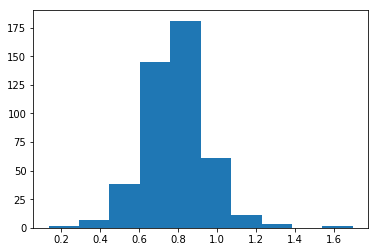

In [22]:
plt.hist((tourist_index.tourist))

In [23]:
#add generate list where tourist index was not capable of creating
no_index_station = pd.DataFrame(list(set(df_weekday_median.STATION).difference( set(tourist_index.STATION))))
no_index_station['tourist'] = tourist_index.tourist.median()
no_index_station = no_index_station.rename(columns= {0:'STATION'})
no_index_station.sample(5)

,STATION,tourist
16,METROPOLITAN AV/M,0.785128
3,NEWARK HM HE/1,0.785128
13,CENTRAL AV/M,0.785128
4,TWENTY THIRD ST/1,0.785128
15,KNICKERBOCKER/M,0.785128


In [24]:
#input average for missing values

In [25]:
tourist_index = tourist_index[['STATION','tourist']].append(no_index_station).reset_index(drop=True)
tourist_index.sample(5)

,STATION,tourist
374,NOSTRAND AV/3,0.796344
323,JAMAICA VAN WK/E,0.722961
271,EASTCHSTER/DYRE/5,0.294606
114,55 ST/D,0.640662
423,TIMES SQ-42 ST/1237ACENQRSW,0.675734


In [26]:
sorted_df_weekday = sorted_df_weekday.merge(tourist_index, how = 'inner', left_on= 'STATION', right_on= 'STATION')
sorted_df_weekday['passages_local'] = sorted_df_weekday['passages'] / sorted_df_weekday['tourist']


In [27]:
sorted_df_weekend= sorted_df_weekend.merge(tourist_index, how = 'inner', left_on ='STATION', right_on='STATION')
sorted_df_weekend['passages_local'] = sorted_df_weekend.passages / sorted_df_weekend.tourist


In [28]:
top_weekend=sorted_df_weekend.groupby('STATION', as_index = False).mean().sort_values(by = 'passages_local',ascending = False)
top_weekend=top_weekend[0:6]['STATION']
top_weekend

146                     8 AV/N
31                 145 ST/ABCD
380             NOSTRAND AV/AC
201               BEDFORD AV/L
24     14 ST-UNION SQ/456LNQRW
363              MYRTLE AV/JMZ
Name: STATION, dtype: object

In [29]:
top_weekday=sorted_df_weekday.groupby('STATION', as_index= False).mean().sort_values(by='passages_local',ascending =False)
top_weekday=top_weekday[0:6]['STATION']
top_weekday.sample

<bound method NDFrame.sample of 70                        23 ST/FM
103            47-50 STS ROCK/BDFM
97           42 ST-BRYANT PK/BDFM7
39                      168 ST/1AC
429    TIMES SQ-42 ST/ACENQRS1237W
83                       30 AV/NQW
Name: STATION, dtype: object>

In [30]:
weekend_to_plot = sorted_df_weekend[sorted_df_weekend['STATION'].isin(top_weekend)]
weekend_to_plot = weekend_to_plot[weekend_to_plot.TIME!='00:00']
weekend_to_plot = weekend_to_plot[weekend_to_plot.TIME!='04:00']

weekday_to_plot = sorted_df_weekday[sorted_df_weekday['STATION'].isin(top_weekday)]
weekday_to_plot = weekday_to_plot[weekday_to_plot.TIME!='00:00']
weekday_to_plot = weekday_to_plot[weekday_to_plot.TIME!='04:00']


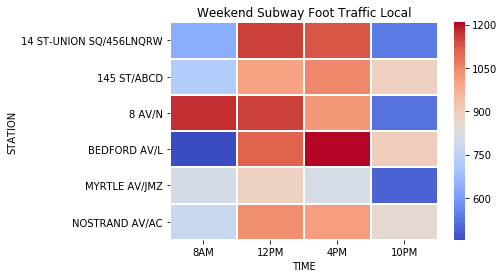

In [31]:
ax = plt.axes()
sns.heatmap(weekend_to_plot.pivot('STATION','TIME','passages_local'),xticklabels =['8AM','12PM','4PM', '10PM'],linewidths=1,ax =ax,
           cmap='coolwarm')
ax.set_title('Weekend Subway Foot Traffic Local')
plt.savefig('weekendSubwayFootTraffic.svg',bbox_inches="tight")
plt.show();

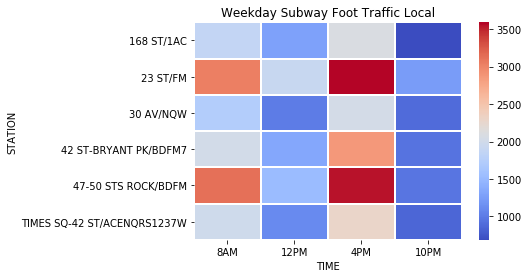

In [32]:
ax = plt.axes()
sns.heatmap(weekday_to_plot.pivot('STATION','TIME','passages_local'),xticklabels =['8AM','12PM','4PM', '10PM'],linewidths=1,
           cmap ='coolwarm',ax=ax)
ax.set_title('Weekday Subway Foot Traffic Local')
plt.savefig('weekdaySubwayFootTraffic.svg',bbox_inches="tight")
plt.show;